# LifeSnaps Preprocessing Experiments

#### Import de llibreries necessaries

In [100]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('../data/df_cleaned.csv')

print(f"Shape: {df.shape}")

Shape: (7410, 24)


## Lectura de dades i split de train / test

In [60]:
# Comprovem quina es les estructura de les nostres dades faltants en el target
TARGET = 'TIRED'

df_complete = df.dropna(subset=[TARGET])

df_null_targets = df[df["TIRED"].isnull()]

print(f"Estructura dades amb target:\n{df_complete.shape}")
print(f"Estructura dades target null:\n{df_null_targets.shape}")

Estructura dades amb target:
(2290, 24)
Estructura dades target null:
(5120, 24)


In [4]:
# Difinim X i el target y
# Prediccio de TIRED
X = df_complete.drop(columns=[TARGET])
y = df_complete[TARGET]

numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

print(f"\nCol. numeriques ({len(numerical_features)}): \n{numerical_features}")
print(f"Col. categoriques ({len(categorical_features)}): \n{categorical_features}")




Col. numeriques (20): 
['nightly_temperature', 'nremhr', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'daily_temperature_variation', 'calories', 'bpm', 'sedentary_minutes', 'resting_hr', 'minutesAsleep', 'minutesAwake', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'bmi']
Col. categoriques (3): 
['age', 'gender', 'bmi_tipo']


### Train / Test Split

In [98]:
# Estratifiquem respecte un dels targets per tal d'assegurar el bon split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print('\n','--'*50)
print(f"\nDistribució train:\n{y_train.value_counts(normalize=True)}")
print(f"\nDistribució test:\n{y_test.value_counts(normalize=True)}")



Train shape: (1832, 23)
Test shape: (458, 23)

 ----------------------------------------------------------------------------------------------------

Distribució train:
TIRED
0.0    0.615721
1.0    0.384279
Name: proportion, dtype: float64

Distribució test:
TIRED
0.0    0.615721
1.0    0.384279
Name: proportion, dtype: float64


### Preprocessador utilitzat inicial

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)])


### Classifiers i Grids que utilitzarem

In [7]:
# Define classifiers
CLASSIFIERS = {
    "MLP": MLPClassifier(random_state=42, max_iter=500),
    "SVM": SVC(random_state=42, probability=True),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Param grids pel GridSearchCV
# Complexitat reduida per tal que no porti un temps exegerat de execució
# Un cop trobem el model bó podrem augmenter la complexitat del model
PARAM_GRIDS = {
    "MLP": {
        "classifier__hidden_layer_sizes": [(100,), (100, 50)],
        "classifier__alpha": [1e-4, 1e-3, 1e-2],

    },
    "SVM": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ["rbf"], # Si hi ha bons resultats provar d'altres
        "classifier__gamma": ["scale", "auto", 0.01]
    },
    "RandomForest": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [None, 10, 20],
        "classifier__class_weight": ["balanced", "balanced_subsample"]
    },
    "GradientBoosting": {
        "classifier__n_estimators": [200, 400],
        "classifier__learning_rate": [0.05, 0.1],
        "classifier__max_depth": [3, 5]
    }
}

## ENTRENAMENT DEL MODEL BASE

In [ ]:
# Provarem de apuntar al accuracy o al f1 score de la classe 1, 
f1_cls1 = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
base_results = []
base_models = {}


for model, classifier in CLASSIFIERS.items():
    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", classifier)
    ])

    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=PARAM_GRIDS[model],
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)


    best = gs.best_estimator_
    base_models[model] = best
    
    y_pred = best.predict(X_test)

    report = classification_report(
        y_test,
        y_pred, # Fem un predict amb el millor model trobat i comparem
        labels=[0, 1],
        output_dict=True,
        zero_division=0
    )

    base_results.append({
        "Target":                TARGET,
        "Experiment":            "Entrenament basic",
        "Model":                 model,
        "Best Params":           gs.best_params_,
        "Best CV":               gs.best_score_,
        "Test Precision (1)":    report["1"]["precision"],
        "Test Recall (1)":       report["1"]["recall"],
        "Test F1 (1)":           report["1"]["f1-score"],
        "Test F1 (macro global)": f1_score(y_test, y_pred, average="macro"),
        "Test Accuracy":         report["accuracy"],
    })

    print(f"{model:20s} | Best CV: {gs.best_score_:.4f} | Test F1(cl1): {report["1"]["f1-score"]:.4f} | Acc: {report["accuracy"]:.4f}")

MLP                  | Best CV: 0.5944 | Test F1(cl1): 0.4667 | Acc: 0.5808
SVM                  | Best CV: 0.6010 | Test F1(cl1): 0.4713 | Acc: 0.5983
RandomForest         | Best CV: 0.6332 | Test F1(cl1): 0.4863 | Acc: 0.6310
GradientBoosting     | Best CV: 0.6125 | Test F1(cl1): 0.4337 | Acc: 0.5895


In [34]:
# Convertim en un DataFrame
base_results_df = pd.DataFrame(base_results)

display_cols = ["Target","Experiment","Model","Best CV","Test F1 (1)","Test F1 (macro global)","Test Accuracy"]

display(base_results_df[display_cols].round(4))


,Target,Experiment,Model,Best CV,Test F1 (1),Test F1 (macro global),Test Accuracy
0,TIRED,Entrenament basic,MLP,0.5944,0.4667,0.5607,0.5808
1,TIRED,Entrenament basic,SVM,0.6010,0.4713,0.5737,0.5983
2,TIRED,Entrenament basic,RandomForest,0.6332,0.4863,0.5992,0.6310
3,TIRED,Entrenament basic,GradientBoosting,0.6125,0.4337,0.5559,0.5895


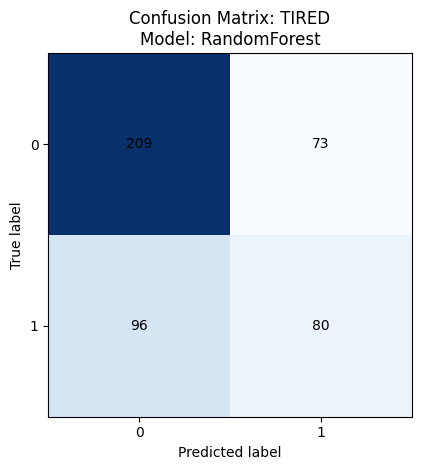

In [35]:

best_acc = base_results_df["Test F1 (1)"].idxmax()

best_model_name = base_results_df.loc[best_acc, "Model"]
best_model = base_models[best_model_name]

# Predict and compute confusion matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig = plt.figure()
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title(f"Confusion Matrix: {TARGET}\nModel: {best_model_name}")
plt.xlabel("Predicted label")
plt.ylabel("True label")
tick_marks = [0, 1]
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Annotate each cell with the count
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

## EXPERIMENT 1: Importancia de les caracteristiques

Entrenem RandomForest per indentificar les caracteristiques més importants (10-15), posteriorment entrenem els models utilitzant aquestes 10-15 característiques, per veure si augmenta el rendiment del model. Proavarem tambe amb permutation importances.

### Feature Importance

La Gini importance d’una feature és: La suma de totes les reduccions d’impuresa (Gini) que ha causat al llarg de tots els arbres i de totes les seves aparicions.

Millors paràmetres: {'clf__max_depth': 15, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 8, 'clf__n_estimators': 300}
CV Score: 0.6386
Test F1 (clase=1): 0.5248
Test Accuracy:     0.6441
Top-10 features: ['bpm', 'calories', 'steps', 'resting_hr', 'minutesAsleep', 'daily_temperature_variation', 'sedentary_minutes', 'nightly_temperature', 'bmi', 'minutesAwake']
Top-15 features: ['bpm', 'calories', 'steps', 'resting_hr', 'minutesAsleep', 'daily_temperature_variation', 'sedentary_minutes', 'nightly_temperature', 'bmi', 'minutesAwake', 'stress_score', 'sleep_deep_ratio', 'sleep_light_ratio', 'sleep_efficiency', 'sleep_wake_ratio']


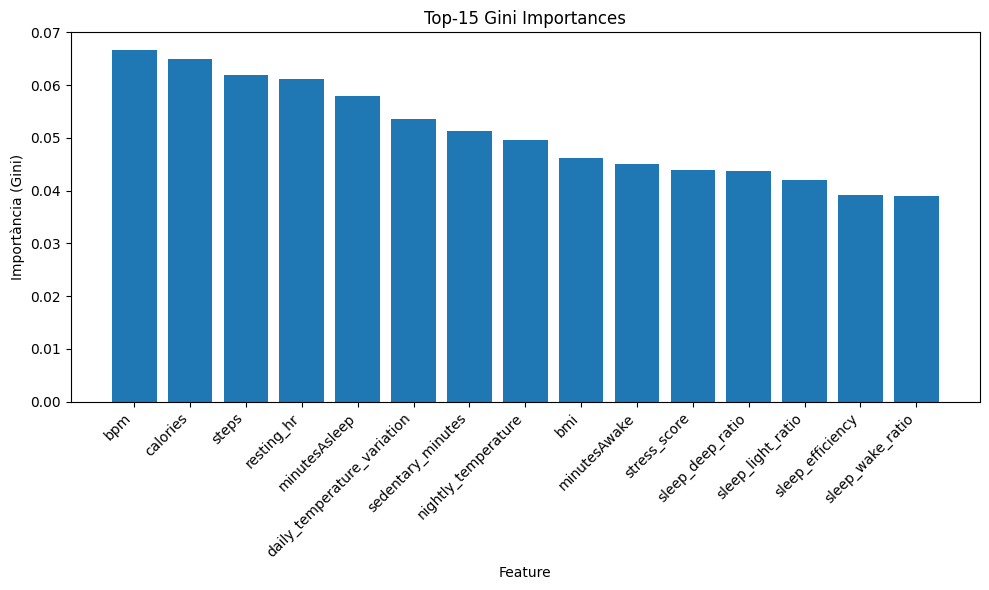

In [87]:
# -----------------------------------------------
# 1. Param grid & pipeline bàsic
# -----------------------------------------------
param_grid_rf = {
    "clf__n_estimators":      [100, 200, 300],
    "clf__max_depth":         [None, 15, 30],
    "clf__min_samples_split": [2, 4, 8],
    "clf__min_samples_leaf":  [1, 2, 4]
}

base_pipe_rf = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1))
])

# -----------------------------------------------
# 2. Entrenament + selecció del millor model
# -----------------------------------------------
gs = GridSearchCV(
    estimator=base_pipe_rf,
    param_grid=param_grid_rf,
    scoring="accuracy",   # accuracy o f1_score
    cv=cv,
    n_jobs=-1,
    refit=True
)
gs.fit(X_train, y_train)

best_model = gs.best_estimator_
print("Millors paràmetres:", gs.best_params_)
print("CV Score:", round(gs.best_score_, 4))

# -----------------------------------------------
# 3. Extracció dels noms de feature després del preproc
# -----------------------------------------------
# suposant que tens variables numerical_features i categorical_features
preproc = best_model.named_steps["preprocessor"]
cat_pipe = preproc.named_transformers_["cat"]
ohe = cat_pipe.named_steps.get("onehot") or cat_pipe.named_steps.get("encode")

ohe_names = ohe.get_feature_names_out(categorical_features)
all_features = numerical_features + list(ohe_names)

# -----------------------------------------------
# 4. Importàncies Gini i agregació per feature “base”
# -----------------------------------------------
importances_raw = pd.Series(
    best_model.named_steps["clf"].feature_importances_,
    index=all_features
)

def base_name(feat):
    # si la feature ve d'una codificació one-hot d'una cat_feature
    for cat in categorical_features:
        prefix = f"{cat}_"
        if feat.startswith(prefix):
            return cat
    return feat

agg_importances = (
    importances_raw
    .groupby(base_name)
    .sum()
    .sort_values(ascending=False)
)

# -----------------------------------------------
# 5. Mètriques sobre el test set
# -----------------------------------------------
y_pred = best_model.predict(X_test)
f1_test = f1_score(y_test, y_pred, pos_label=1)
acc_test = accuracy_score(y_test, y_pred)

print(f"Test F1 (clase=1): {f1_test:.4f}")
print(f"Test Accuracy:     {acc_test:.4f}")

# -----------------------------------------------
# 6. Top-10 i Top-15 importàncies
# -----------------------------------------------
top10 = agg_importances.head(10).index.tolist()
top15 = agg_importances.head(15).index.tolist()
print("Top-10 features:", top10)
print("Top-15 features:", top15)

# -----------------------------------------------
# 7. Visualització de les Top-15 importàncies
# -----------------------------------------------
plt.figure(figsize=(10, 6))
plt.bar(agg_importances.head(15).index, agg_importances.head(15).values)
plt.xticks(rotation=45, ha="right")
plt.title("Top-15 Gini Importances")
plt.xlabel("Feature")
plt.ylabel("Importància (Gini)")
plt.tight_layout()
plt.show()


### Rentrenament de models 10-15 millors features

In [88]:

# Recuperem el millor model i els transformers originals
best_rf_model    = best_model  # de l’script anterior
orig_preproc     = best_rf_model.named_steps["preprocessor"]
num_pipeline     = orig_preproc.named_transformers_["num"]
cat_pipeline     = orig_preproc.named_transformers_["cat"]

# xtraiem els paràmetres òptims per al RandomForest (sense prefix “clf__”)
rf_params = {
    key.replace("clf__", ""): val
    for key, val in gs.best_params_.items()
}

# Definim els dos conjunts de features
feature_sets = {
    "Top10": top10,   # llista de 10 noms de feature “base”
    "Top15": top15    # llista de 15 noms de feature “base”
}

# Reentrenament i avaluació per a cada subset
topk_results = []
fi_models = {}

for label, feats in feature_sets.items():
    # Separem variables numèriques i categòriques del subset
    num_feats = [f for f in feats if f in numerical_features]
    cat_feats = [f for f in feats if f in categorical_features]

    # Construïm un nou preprocessor que només treballi amb aquestes columnes
    preproc_sub = ColumnTransformer([
        ("num", num_pipeline, num_feats),
        ("cat", cat_pipeline, cat_feats)
    ], remainder="drop")

    # Pipeline amb SMOTE i RandomForest amb els paràmetres trobats
    pipe_sub = ImbPipeline([
        ("preprocessor", preproc_sub),
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(
            class_weight="balanced",
            random_state=42,
            n_jobs=-1,
            **rf_params
        ))
    ])

    # Fit i predict
    pipe_sub.fit(X_train[feats], y_train)
    y_pred = pipe_sub.predict(X_test[feats])

    # Guardem el model
    fi_models[label] = {"RandomForest": pipe_sub}
    
    report = classification_report(
            y_test,
            y_pred, # Fem un predict amb el millor model trobat i comparem
            labels=[0, 1],
            output_dict=True,
            zero_division=0
        )

    topk_results.append({
        "Target":                TARGET,
        "Experiment":            f"Top_{label}",
        "Model":                 model,
        "Best Params":           gs.best_params_,
        "Best CV":               gs.best_score_,
        "Test Precision (1)":    report["1"]["precision"],
        "Test Recall (1)":       report["1"]["recall"],
        "Test F1 (1)":           report["1"]["f1-score"],
        "Test F1 (macro global)": f1_score(y_test, y_pred, average="macro"),
        "Test Accuracy":         report["accuracy"],
    })

    print(f"{label:20s} | Best CV: {gs.best_score_:.4f} | Test F1(cl1): {report["1"]["f1-score"]:.4f} | Acc: {report["accuracy"]:.4f}")

Top10                | Best CV: 0.6386 | Test F1(cl1): 0.4848 | Acc: 0.6288
Top15                | Best CV: 0.6386 | Test F1(cl1): 0.5057 | Acc: 0.6201


In [36]:
feature_importance_results_df = pd.DataFrame(topk_results)

display(feature_importance_results_df[display_cols].round(4))

,Target,Experiment,Model,Best CV,Test F1 (1),Test F1 (macro global),Test Accuracy
0,TIRED,Top_Top10,GradientBoosting,0.6386,0.4848,0.5559,0.6288
1,TIRED,Top_Top15,GradientBoosting,0.6386,0.5057,0.5559,0.6201


### Permutation Importance

=== Permutation importance ===

Top-15 features (Permutation F1):


,importance
bmi_tipo,0.024163
daily_temperature_variation,0.023872
bmi,0.020160
full_sleep_breathing_rate,0.018923
bpm,0.016084
sedentary_minutes,0.015429
gender,0.013173
steps,0.010844
resting_hr,0.010189
sleep_efficiency,0.009971


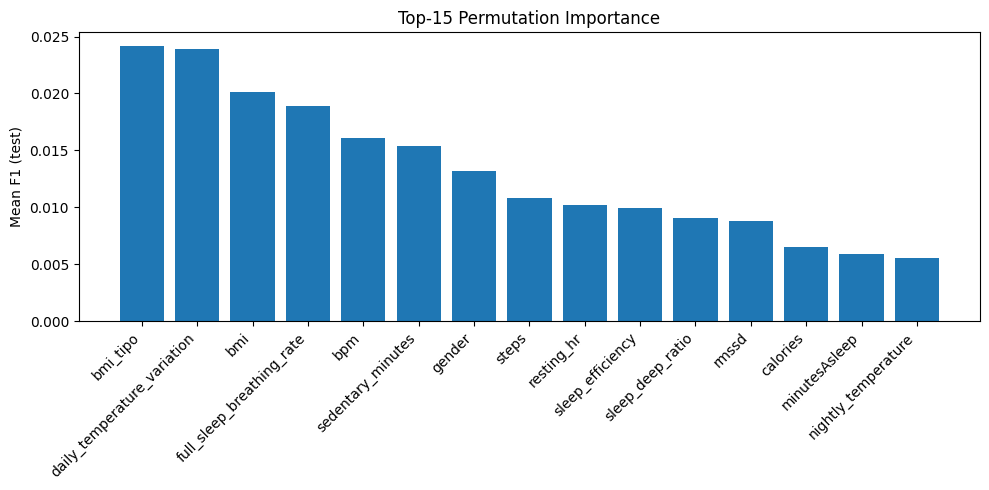

In [40]:
# -----------------------------------------------
# 1. Calcular permutation importance
# -----------------------------------------------
print("=== Permutation importance ===")
result = permutation_importance(
    best_rf_model,      # el teu model entrenat per al sol target
    X_test, y_test,
    n_repeats=30,
    n_jobs=-1,
    random_state=42
)

# -----------------------------------------------
# 2. Crear sèrie d’importàncies amb noms originals
# -----------------------------------------------
orig_features = X_test.columns.tolist()


perm_importances = (
    pd.Series(result.importances_mean, index=orig_features)
      .sort_values(ascending=False)
)

# -----------------------------------------------
# 3. Extreure Top-10 i Top-15
# -----------------------------------------------
perm_top_features = {
    10: perm_importances.head(10).index.tolist(),
    15: perm_importances.head(15).index.tolist()
}

# -----------------------------------------------
# 4. Mostrar la taula i la gràfica Top-15
# -----------------------------------------------
print("\nTop-15 features (Permutation F1):")
display(perm_importances.head(15).to_frame("importance"))

plt.figure(figsize=(10, 5))
top15 = perm_importances.head(15)
plt.bar(top15.index, top15.values)
plt.title("Top-15 Permutation Importance")
plt.ylabel("Mean F1 (test)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Reentrenament Permutation importance

In [46]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score


# Resultats i models per a Top-k
perm_topk_results = []
perm_topk_models  = {}

for k in [10, 15]:
    sel_feats = perm_top_features[k]
    num_sel   = [f for f in sel_feats if f in numerical_features]
    cat_sel   = [f for f in sel_feats if f in categorical_features]

    # --- pre-processador limitat als top-k ---
    transformers = []
    if num_sel:
        transformers.append(("num", numeric_transformer, num_sel))
    if cat_sel:
        transformers.append(("cat", categorical_transformer, cat_sel))
    preproc_top = ColumnTransformer(transformers, remainder="drop")

    # Guarda els models per a cada k
    perm_topk_models[k] = {}

    for model_name, classifier in CLASSIFIERS.items():
        pipe = ImbPipeline([
            ("preprocessor", preproc_top),
            ("smote",        SMOTE(random_state=42)),
            ("classifier",   classifier)
        ])

        gs = GridSearchCV(
            pipe,
            PARAM_GRIDS[model_name],
            scoring="accuracy",
            cv=cv,
            n_jobs=-1,
            refit=True
        )
        # Entrena sobre les features seleccionades
        gs.fit(X_train[sel_feats], y_train)

        best_est = gs.best_estimator_
        perm_topk_models[k][model_name] = best_est

        # Predicció i informe
        y_pred = best_est.predict(X_test[sel_feats])
        report = classification_report(
            y_test,
            y_pred,
            labels=[0, 1],
            output_dict=True,
            zero_division=0
        )
      
        # Afegeix resultats amb les mateixes columnes de la referència
        perm_topk_results.append({
            "Target":                TARGET,
            "Experiment":            f"Perm_Top_{k}",
            "Model":                 model_name,
            "Best Params":           gs.best_params_,
            "Best CV":               gs.best_score_,
            "Test Precision (1)":    report["1"]["precision"],
            "Test Recall (1)":       report["1"]["recall"],
            "Test F1 (1)":           report["1"]["f1-score"],
            "Test F1 (macro global)": f1_score(y_test, best_est.predict(X_test), average="macro"),
            "Test Accuracy":         report["accuracy"],
        })

        print(f"Perm Top_{k:2d}  Best CV: {gs.best_score_:.4f} | Test F1(cl1): {report["1"]["f1-score"]:.4f} | Acc: {report["accuracy"]:.4f}")


Perm Top_10  Best CV: 0.6206 | Test F1(cl1): 0.5042 | Acc: 0.6135
Perm Top_10  Best CV: 0.6272 | Test F1(cl1): 0.4809 | Acc: 0.6135
Perm Top_10  Best CV: 0.6397 | Test F1(cl1): 0.5220 | Acc: 0.6681
Perm Top_10  Best CV: 0.6163 | Test F1(cl1): 0.4479 | Acc: 0.6070
Perm Top_15  Best CV: 0.6053 | Test F1(cl1): 0.4845 | Acc: 0.6004
Perm Top_15  Best CV: 0.6217 | Test F1(cl1): 0.4958 | Acc: 0.6048
Perm Top_15  Best CV: 0.6212 | Test F1(cl1): 0.5238 | Acc: 0.6507
Perm Top_15  Best CV: 0.6081 | Test F1(cl1): 0.5015 | Acc: 0.6397


In [47]:
perm_topk_results_df = pd.DataFrame(perm_topk_results)
display(perm_topk_results_df[display_cols].round(4))

,Target,Experiment,Model,Best CV,Test F1 (1),Test F1 (macro global),Test Accuracy
0,TIRED,Perm_Top_10,MLP,0.6206,0.5042,0.5938,0.6135
1,TIRED,Perm_Top_10,SVM,0.6272,0.4809,0.5866,0.6135
2,TIRED,Perm_Top_10,RandomForest,0.6397,0.5220,0.6339,0.6681
3,TIRED,Perm_Top_10,GradientBoosting,0.6163,0.4479,0.5714,0.6070
4,TIRED,Perm_Top_15,MLP,0.6053,0.4845,0.5792,0.6004
5,TIRED,Perm_Top_15,SVM,0.6217,0.4958,0.5854,0.6048
6,TIRED,Perm_Top_15,RandomForest,0.6212,0.5238,0.6240,0.6507
7,TIRED,Perm_Top_15,GradientBoosting,0.6081,0.5015,0.6097,0.6397


## EXPERIMENT 2: PCA


Es realitza una anàlisi de components principals (PCA) per examinar com evolucionen els components més rellevants del conjunt de dades en termes de variància explicada acumulada, considerant els primers 5, 10, 15, 20 i 25 components

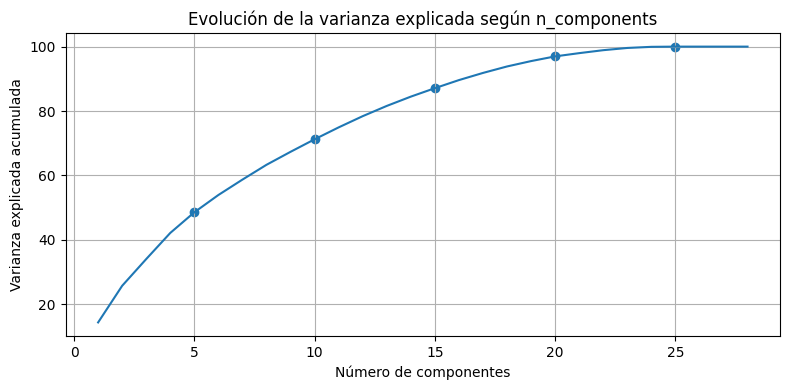

In [48]:
# 1) Transformar X_train con tu preprocesador
X_train_trans = preprocessor.fit_transform(X_train)


# 2) Ajustar PCA con todos los componentes posibles
pca = PCA(random_state=42)
pca.fit(X_train_trans)

# 3) Calcular la varianza explicada acumulada
explained_cumsum = pca.explained_variance_ratio_.cumsum()*100

# 4) Definir los puntos de interés y extraer sus valores
ks = [5, 10, 15, 20, 25]
cums = explained_cumsum[[k-1 for k in ks]]

# 5) Dibujar la curva completa y señalar los ks elegidos
plt.figure(figsize=(8, 4))
plt.plot(
    range(1, len(explained_cumsum) + 1),
    explained_cumsum,
)
plt.scatter(ks, cums)
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Evolución de la varianza explicada según n_components')
plt.grid(True)
plt.tight_layout()
plt.show()

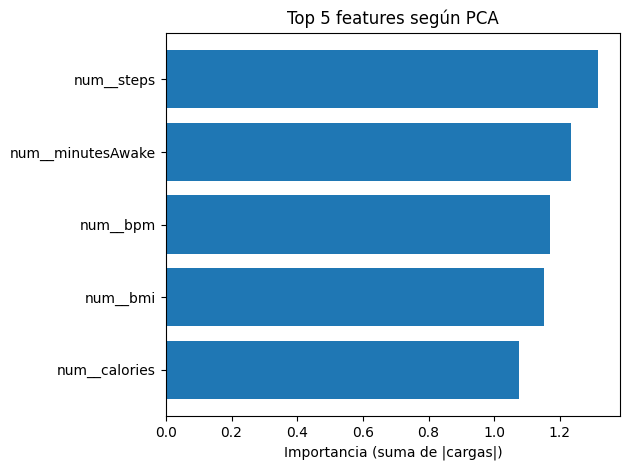

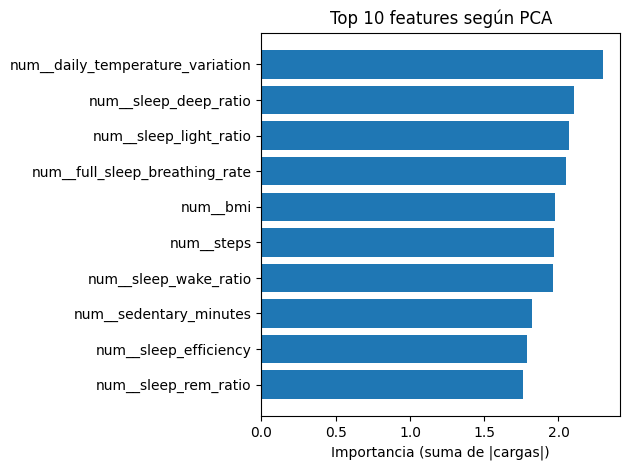

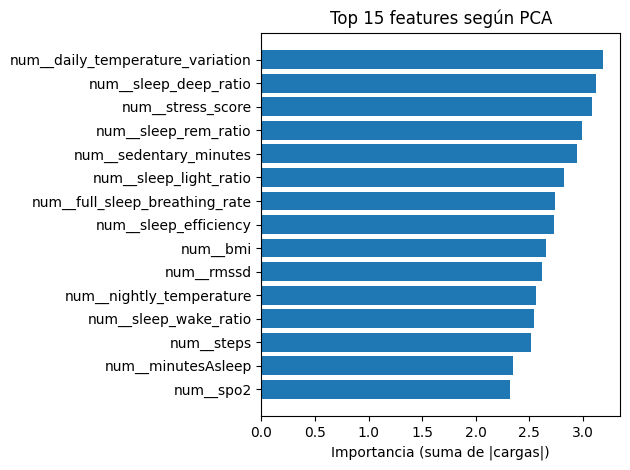

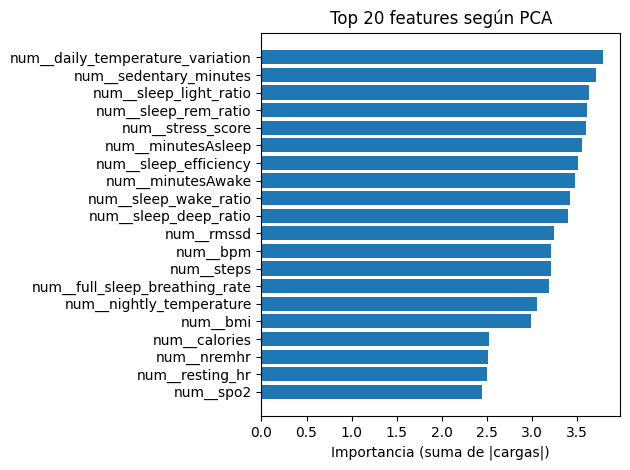

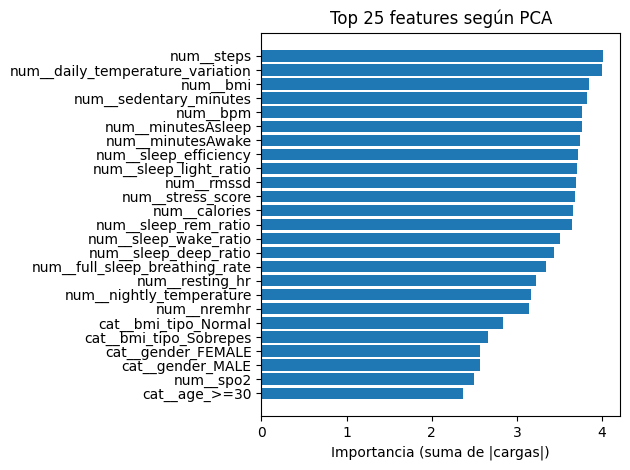

In [49]:
# 1) Nombres de las features resultantes
pca_names = preprocessor.get_feature_names_out()

# 2) Para cada k en [5,10,15,20,25], ajusta un PCA y extrae las importancias
n_components_list = [5, 10, 15, 20, 25]
for k in n_components_list:
    # Ajusta PCA
    pca = PCA(n_components=k, random_state=42)
    pca.fit(X_train_trans)

    # loadings: matriz (n_features, k)
    loadings = pca.components_.T

    # importancia = suma de cargas absolutas de cada feature en todos los componentes
    importance = np.sum(np.abs(loadings), axis=1)

    # crea DataFrame, ordena y toma top-k
    df_imp = pd.DataFrame({
        'feature':    pca_names,
        'importance': importance
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    topk = df_imp.head(k)

    plt.figure()
    plt.barh(topk['feature'][::-1], topk['importance'][::-1])
    plt.xlabel('Importancia (suma de |cargas|)')
    plt.title(f'Top {k} features según PCA')
    plt.tight_layout()
    plt.show()

Aquests gràfics mostren, per cada valor de *k* (5, 10, 15, 20 i 25 components), quines variables original s’aporten més a l’espai de la PCA i, per tant, expliquen més variància del conjunt de dades.

* **Components principals**: són noves variables creades com a combinacions lineals de les variables originals.
* **Càrregues (loadings)**: cada component té un coeficient per a cada variable; aquell coeficient indica quant “pesa” la variable en aquest eix.
* **Importància de la variable**: per a cada variable, sumem el valor absolut de les càrregues als primers *k* components. Una suma més alta vol dir que la variable contribueix de manera rellevant a la variació capturada per aquests *k* eixos.

Així podem veure quines són les *k* variables que més pesen ens diu quins atributs són més informatius (i quins, en canvi, aporten informació redundant).
Els tops *k* ajuden a identificar les característiques més representatives del dataset segons la PCA.


In [51]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# 0) Defineix el teu nom de target si vols guardar-lo
TARGET = "el_teu_target"

# Guarda resultats i models
pca_results = []
pca_models = {}


for k in n_components_list:
    print(f"\n-- PCA - {k} components --")
    pca_models[k] = {}

    for model, classifier in CLASSIFIERS.items():
        # 1) Pipeline amb preprocessor, SMOTE, PCA i classificador
        pipeline = ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote",        SMOTE(random_state=42)),
            ("pca",          PCA(n_components=k, random_state=42)),
            ("classifier",   classifier)
        ])

        # 2) Grid search
        gs = GridSearchCV(
            pipeline,
            PARAM_GRIDS[model],
            scoring=f1_cls1,
            cv=cv,
            n_jobs=-1,
            refit=True
        )
        gs.fit(X_train, y_train)

        # Guarda el millor model
        best_est = gs.best_estimator_
        pca_models[k][model] = best_est

        # 4) Avaluació al test
        y_pred = best_est.predict(X_test)
        report = classification_report(
            y_test,
            y_pred,
            labels=[0, 1],
            output_dict=True,
            zero_division=0
        )


        # 5) Emmagatzema els resultats amb la mateixa estructura
        pca_results.append({
            "Target":                TARGET,
            "Model":                 model,
            "Experiment":            f"PCA_{k}",
            "Best Params":           gs.best_params_,
            "Best CV":  gs.best_score_,
            "Test Precision (1)":    report["1"]["precision"],
            "Test Recall (1)":       report["1"]["recall"],
            "Test F1 (1)":           report["1"]["f1-score"],
            "Test F1 (macro global)": f1_score(y_test, y_pred, average="macro"),
            "Test Accuracy":         report["accuracy"]
        })

        print(f"{model:20s} | Best CV: {gs.best_score_:.4f} | Test F1(cl1): {report["1"]["f1-score"]:.4f} | Acc: {report["accuracy"]:.4f}")



-- PCA - 5 components --
MLP                  | Best CV: 0.4808 | Test F1(cl1): 0.4675 | Acc: 0.5524
SVM                  | Best CV: 0.5009 | Test F1(cl1): 0.5290 | Acc: 0.5568
RandomForest         | Best CV: 0.4717 | Test F1(cl1): 0.4132 | Acc: 0.5349
GradientBoosting     | Best CV: 0.4740 | Test F1(cl1): 0.4348 | Acc: 0.5459

-- PCA - 10 components --
MLP                  | Best CV: 0.4854 | Test F1(cl1): 0.4959 | Acc: 0.6004
SVM                  | Best CV: 0.4921 | Test F1(cl1): 0.5041 | Acc: 0.6004
RandomForest         | Best CV: 0.4789 | Test F1(cl1): 0.5056 | Acc: 0.6114
GradientBoosting     | Best CV: 0.4803 | Test F1(cl1): 0.4294 | Acc: 0.5590

-- PCA - 15 components --
MLP                  | Best CV: 0.4713 | Test F1(cl1): 0.4944 | Acc: 0.6026
SVM                  | Best CV: 0.4833 | Test F1(cl1): 0.5027 | Acc: 0.5939
RandomForest         | Best CV: 0.4667 | Test F1(cl1): 0.4958 | Acc: 0.6092
GradientBoosting     | Best CV: 0.4700 | Test F1(cl1): 0.4828 | Acc: 0.5742

-- PCA 

In [53]:
pca_results_df = pd.DataFrame(pca_results)
display(pca_results_df[display_cols].round(4))

,Target,Experiment,Model,Best CV F1 (clase 1),Test F1 (1),Test F1 (macro global),Test Accuracy
0,el_teu_target,PCA_5,MLP,0.4808,0.4675,0.5407,0.5524
1,el_teu_target,PCA_5,SVM,0.5009,0.5290,0.5552,0.5568
2,el_teu_target,PCA_5,RandomForest,0.4717,0.4132,0.5140,0.5349
3,el_teu_target,PCA_5,GradientBoosting,0.4740,0.4348,0.5276,0.5459
4,el_teu_target,PCA_10,MLP,0.4854,0.4959,0.5825,0.6004
5,el_teu_target,PCA_10,SVM,0.4921,0.5041,0.5848,0.6004
6,el_teu_target,PCA_10,RandomForest,0.4789,0.5056,0.5927,0.6114
7,el_teu_target,PCA_10,GradientBoosting,0.4803,0.4294,0.5350,0.5590
8,el_teu_target,PCA_15,MLP,0.4713,0.4944,0.5836,0.6026
9,el_teu_target,PCA_15,SVM,0.4833,0.5027,0.5798,0.5939


## EXPERIMENT 3: KNN Imputation

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score

# 1) Transformers amb KNN per a numèriques i categòriques
knn_numeric_transformer = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler",  StandardScaler())
])

knn_categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor_knn = ColumnTransformer([
    ("num", knn_numeric_transformer, numerical_features),
    ("cat", knn_categorical_transformer, categorical_features)
], remainder="drop")

# 2) Entrenament amb KNN Imputation
knn_results = []                
knn_models  = {}                    

    
for model_name, classifier in CLASSIFIERS.items():
    pipe = ImbPipeline([
        ("preprocessor", preprocessor_knn),
        ("smote",        SMOTE(random_state=42)),
        ("classifier",   classifier)
    ])
    
    gs = GridSearchCV(
        pipe,
        PARAM_GRIDS[model_name],
        scoring=f1_cls1,
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)
    
    best_est = gs.best_estimator_
    knn_models[model_name] = best_est
    
    y_pred = best_est.predict(X_test)
    report = classification_report(
        y_test, y_pred,
        labels=[0, 1],
        output_dict=True,
        zero_division=0
    )
    
    knn_results.append({
        "Target":                TARGET,
        "Experiment":            "KNN_Imputation",
        "Model":                 model_name,
        "Best Params":           gs.best_params_,
        "Best CV":               gs.best_score_,
        "Test Precision (1)":    report["1"]["precision"],
        "Test Recall (1)":       report["1"]["recall"],
        "Test F1 (1)":           report["1"]["f1-score"],
        "Test F1 (macro global)": f1_score(y_test, y_pred, average="macro"),
        "Test Accuracy":         report["accuracy"],
    })
    
    print(f"{model_name:20s} | Best CV: {gs.best_score_:.4f} | Test F1(cl1): {report['1']['f1-score']:.4f} | Acc: {report["accuracy"]:.4f}")


MLP                  | Best CV: 0.4669 | Test F1(cl1): 0.5013 | Acc: 0.5961
SVM                  | Best CV: 0.4882 | Test F1(cl1): 0.5296 | Acc: 0.6004
RandomForest         | Best CV: 0.4807 | Test F1(cl1): 0.4970 | Acc: 0.6288
GradientBoosting     | Best CV: 0.4752 | Test F1(cl1): 0.4812 | Acc: 0.6092


In [58]:
# 3) DataFrame resum
knn_df = pd.DataFrame(knn_results)

display(knn_df[display_cols].round(4))

,Target,Experiment,Model,Best CV,Test F1 (1),Test F1 (macro global),Test Accuracy
0,el_teu_target,KNN_Imputation,MLP,0.4669,0.5013,0.5809,0.5961
1,el_teu_target,KNN_Imputation,SVM,0.4882,0.5296,0.5912,0.6004
2,el_teu_target,KNN_Imputation,RandomForest,0.4807,0.4970,0.6015,0.6288
3,el_teu_target,KNN_Imputation,GradientBoosting,0.4752,0.4812,0.5838,0.6092


## EXPERIMENT 4: Target Row augmententation

In [62]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score
import pandas as pd

# ------------------------------------------------------------------
# 0) Preparació de les dades amb missings pel sol target
# ------------------------------------------------------------------
df_missing = df_null_targets.copy()
X_missing = df_missing.drop(columns=[TARGET])
print("Shape of features with missing target:", X_missing.shape)

# ------------------------------------------------------------------
# 1) Generació de pseudo-labels amb el millor model KNN
# ------------------------------------------------------------------
print(f"\nGenerant pseudo-labels per a {TARGET} …")
best_knn_row = (
    knn_df.sort_values("Test Accuracy", ascending=False).head(1)
)

best_knn_model_name = best_knn_row["Model"].iloc[0]
best_knn_model = knn_models[best_knn_model_name]
pseudo_labels = best_knn_model.predict(X_missing)
print(f"  {len(pseudo_labels)} pseudo-labels generades amb {best_knn_model_name}")

# ------------------------------------------------------------------
# 2) Concatena dades originals + pseudo-labels i prepara re-entrenament
# ------------------------------------------------------------------
X_train_aug = pd.concat([X_train, X_missing], ignore_index=True)
y_train_aug = pd.concat([y_train, pd.Series(pseudo_labels)], ignore_index=True)
print("Train augmentat:", X_train_aug.shape)

# ------------------------------------------------------------------
# 3) Retraining sobre dades augmentades
# ------------------------------------------------------------------
target_aug_results = []
target_aug_models  = {}

for model_name, clf in CLASSIFIERS.items():
    print(f"\n=== Retraining · {model_name} sobre dades augmentades ===")
    pipe = ImbPipeline([
        ("preprocessor", preprocessor_knn),  # mateix imputador KNN + OHE
        ("smote",        SMOTE(random_state=42)),
        ("classifier",   clf)
    ])

    gs = GridSearchCV(
        pipe,
        PARAM_GRIDS[model_name],
        scoring=f1_cls1,
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train_aug, y_train_aug)

    best_est = gs.best_estimator_
    target_aug_models[model_name] = best_est

    y_pred    = best_est.predict(X_test)
    report    = classification_report(
        y_test, y_pred,
        labels=[0, 1],
        output_dict=True,
        zero_division=0
    )
    macro_f1  = f1_score(y_test, y_pred, average="macro")
    test_acc  = report["accuracy"]

    target_aug_results.append({
        "Target":                TARGET,
        "Experiment":            "Target_Augmentation",
        "Model":                 model_name,
        "Best Params":           gs.best_params_,
        "Best CV":               gs.best_score_,
        "Test Precision (1)":    report["1"]["precision"],
        "Test Recall (1)":       report["1"]["recall"],
        "Test F1 (1)":           report["1"]["f1-score"],
        "Test F1 (macro global)": macro_f1,
        "Test Accuracy":         test_acc,
    })

    print(f"{model_name:20s} | Best CV: {gs.best_score_:.4f} | Test F1(cl1): {report['1']['f1-score']:.4f} | Acc: {test_acc:.4f}")


Shape of features with missing target: (5120, 23)

Generant pseudo-labels per a TIRED …
  5120 pseudo-labels generades amb RandomForest
Train augmentat: (6952, 24)

=== Retraining · MLP sobre dades augmentades ===
MLP                  | Best CV: 0.7121 | Test F1(cl1): 0.5165 | Acc: 0.6157

=== Retraining · SVM sobre dades augmentades ===
SVM                  | Best CV: 0.7288 | Test F1(cl1): 0.5102 | Acc: 0.5808

=== Retraining · RandomForest sobre dades augmentades ===
RandomForest         | Best CV: 0.7507 | Test F1(cl1): 0.4866 | Acc: 0.6223

=== Retraining · GradientBoosting sobre dades augmentades ===
GradientBoosting     | Best CV: 0.7401 | Test F1(cl1): 0.4458 | Acc: 0.5983


In [63]:
# ------------------------------------------------------------------
# 3) DataFrame resum final
# ------------------------------------------------------------------
aug_df = pd.DataFrame(target_aug_results)
display(aug_df[display_cols].round(4))



,Target,Experiment,Model,Best CV,Test F1 (1),Test F1 (macro global),Test Accuracy
0,TIRED,Target_Augmentation,MLP,0.7121,0.5165,0.5988,0.6157
1,TIRED,Target_Augmentation,SVM,0.7288,0.5102,0.5719,0.5808
2,TIRED,Target_Augmentation,RandomForest,0.7507,0.4866,0.5939,0.6223
3,TIRED,Target_Augmentation,GradientBoosting,0.7401,0.4458,0.5654,0.5983


## Anàlisi de resultats

In [93]:
# --- Results Compilation ---
all_results_dfs = [base_results_df]
if 'feature_importance_results_df' in locals() and not feature_importance_results_df.empty: 
    all_results_dfs.append(feature_importance_results_df)

if 'perm_topk_results_df' in locals() and not perm_topk_results_df.empty: 
    all_results_dfs.append(perm_topk_results_df)

if 'pca_results_df' in locals() and not pca_results_df.empty: 
    all_results_dfs.append(pca_results_df)

if 'knn_imputation_results_df' in locals() and not knn_df.empty: 
    all_results_dfs.append(knn_df)

if 'target_augmentation_results_df' in locals() and not aug_df.empty: 
    all_results_dfs.append(aug_df)

if len(all_results_dfs) > 1:
    combined_results_df = pd.concat(all_results_dfs, ignore_index=True)
    print("\nCombined results from all experiments.")
else:
    print("\nOnly baseline results available.")
    combined_results_df = base_results_df

final_cols = ["Target", "Experiment", "Model", "Test Accuracy","Test F1 (1)", "Test F1 (macro global)","Best Params"]
 
combined_results_df = combined_results_df[final_cols]

# --- Analysis ---
print("\n--- Overall Performance Analysis (Sorted by Test F1-Macro) ---")
combined_results_sorted = combined_results_df.sort_values(by=["Test Accuracy"], ascending=[False]).reset_index(drop=True)


print(f"\n--- Target: {TARGET} ---")
display(combined_results_sorted[final_cols].head().round(4))


Combined results from all experiments.

--- Overall Performance Analysis (Sorted by Test F1-Macro) ---

--- Target: TIRED ---


,Target,Experiment,Model,Test Accuracy,Test F1 (1),Test F1 (macro global),Best Params
0,TIRED,Perm_Top_10,RandomForest,0.6681,0.5220,0.6339,"{'classifier__class_weight': 'balanced', 'clas..."
1,TIRED,Perm_Top_15,RandomForest,0.6507,0.5238,0.6240,{'classifier__class_weight': 'balanced_subsamp...
2,TIRED,Perm_Top_15,GradientBoosting,0.6397,0.5015,0.6097,"{'classifier__learning_rate': 0.1, 'classifier..."
3,TIRED,Entrenament basic,RandomForest,0.6310,0.4863,0.5992,"{'classifier__class_weight': 'balanced', 'clas..."
4,TIRED,Top_Top10,GradientBoosting,0.6288,0.4848,0.5559,"{'clf__max_depth': 15, 'clf__min_samples_leaf'..."



Top 5 models per a TIRED segons Test Accuracy:



,Model,Test Accuracy,Test F1 (1)
0,RandomForest,0.668122,0.522013
1,RandomForest,0.650655,0.523810
2,GradientBoosting,0.639738,0.501511
3,RandomForest,0.631004,0.486322
4,GradientBoosting,0.628821,0.484848


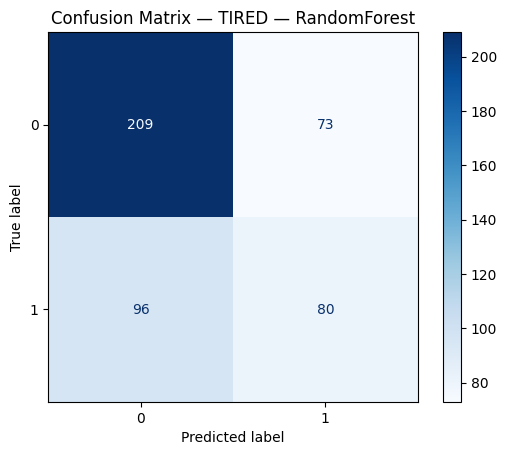

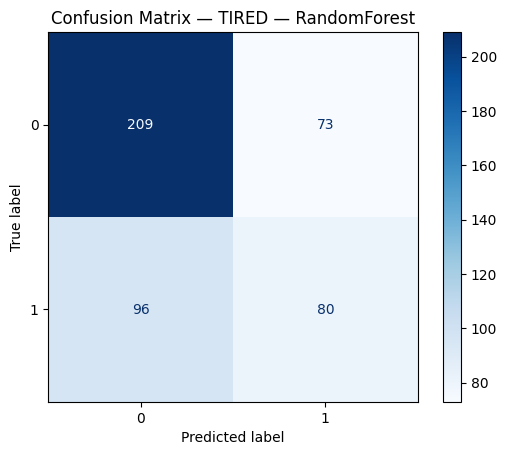

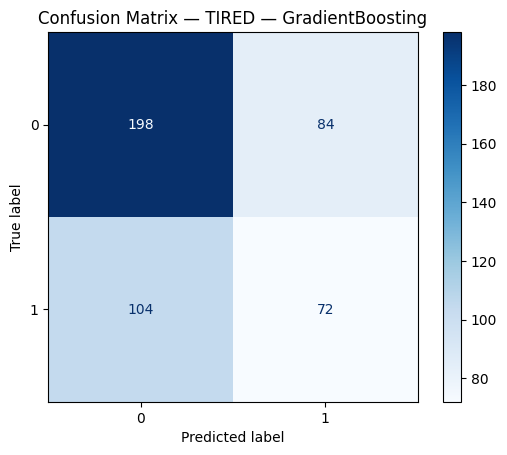

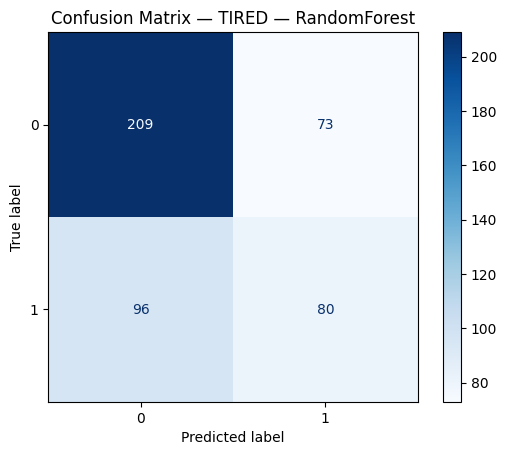

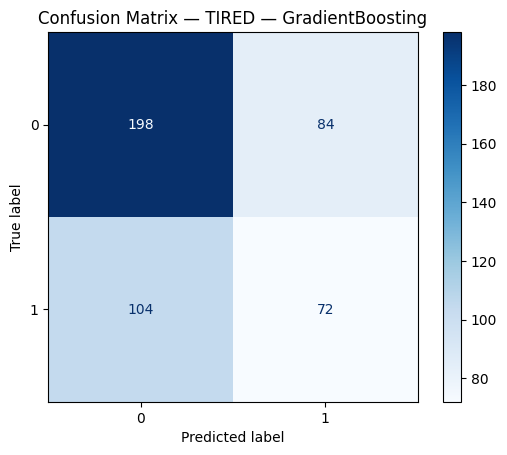

In [97]:
tired_top5 = combined_results_sorted.head(5)

# 2) Mostra la taula resum dels 5 millors
print(f"\nTop 5 models per a {TARGET} segons Test Accuracy:\n")
display(tired_top5[["Model","Test Accuracy","Test F1 (1)"]])

# 3) Dibuixa la matriu de confusió de cada un
for model_name in tired_top5["Model"]:
    clf = base_models[model_name]   # si tens base_models[model_name] enlça directa
    y_pred = clf.predict(X_test)    # X_test, y_test són del target "TIRED"
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix — {TARGET} — {model_name}")
    plt.show()

In [102]:
# ------------------------------------------------------------------
# 0) Paquet i dades Top‑15 (ja calculades)
# ------------------------------------------------------------------
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, make_scorer
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# llista de 15 millors features (Gini o permutació, la que vulguis)
sel_feats   = perm_top_features[10]        # o perm_top_features["TIRED"][15]
num_sel = [f for f in sel_feats if f in numerical_features]
cat_sel = [f for f in sel_feats if f in categorical_features]

transfs = []
if num_sel:
    transfs.append(("num", numeric_transformer, num_sel))
if cat_sel:
    transfs.append(("cat", categorical_transformer, cat_sel))
preproc_top = ColumnTransformer(transfs)

# train_in / val per llindar
X_tr_in, X_val, y_tr_in, y_val = train_test_split(
    X_train, y_train,
    test_size=0.20, stratify=y_train, random_state=42
)

# ------------------------------------------------------------------
# 1) Pipeline
# ------------------------------------------------------------------
pipe = ImbPipeline([
    ("preprocessor", preproc_top),
    ("smote",        SMOTE(random_state=42)),
    ("mlp",          MLPClassifier(max_iter=1500, random_state=42))
])

# ------------------------------------------------------------------
# 2) Hiperparàmetres (distribucions àmplies)
# ------------------------------------------------------------------
from scipy.stats import uniform, randint

param_dist = {
    "mlp__hidden_layer_sizes": [(randint.rvs(50, 250),),               # 1 capa
                                (randint.rvs(80, 200), randint.rvs(30,120)),  # 2 capes
                                (randint.rvs(100, 200), randint.rvs(70,140), randint.rvs(20,70))],   # 3
    "mlp__activation":         ["relu", "tanh", "logistic"],
    "mlp__solver":             ["adam", "lbfgs"],
    "mlp__alpha":              uniform(1e-6, 1e-2),      # 1e‑6 → 1e‑2
    "mlp__learning_rate":      ["constant", "adaptive"],
    "mlp__learning_rate_init": uniform(1e-4, 5e-3),      # 1e‑4 → 5e‑3
    "mlp__batch_size":         [32, 64, 128, 256],
    "mlp__early_stopping":     [True],
    "mlp__tol":                [1e-4, 1e-5],
    "mlp__n_iter_no_change":   [10, 20]
}

f1_cls1 = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ------------------------------------------------------------------
# 3) RandomizedSearch (100 configs → 5 × 100 = 500 fits)
# ------------------------------------------------------------------
rs = RandomizedSearchCV(
    pipe, param_dist, n_iter=100,
    scoring=f1_cls1, 
    cv=cv, 
    n_jobs=-1, 
    refit=True,
    verbose=2, 
    random_state=42
).fit(X_tr_in, y_tr_in)

best_mlp = rs.best_estimator_
print("Millor CV F1(cl1):", round(rs.best_score_, 4))
print("Millors paràmetres:", rs.best_params_)

# ------------------------------------------------------------------
# 4) Llindar òptim (F1 macro) sobre VALIDATION
# ------------------------------------------------------------------
probs_val = best_mlp.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, probs_val)
f1_macro_vals = [f1_score(y_val, (probs_val>=t), average="macro") for t in thr]
thr_opt = thr[int(np.argmax(f1_macro_vals))]
print(f"Llindar òptim: {thr_opt:.3f}")

# ------------------------------------------------------------------
# 5) TEST final
# ------------------------------------------------------------------
probs_test = best_mlp.predict_proba(X_test)[:, 1]
y_pred = (probs_test >= thr_opt).astype(int)

print("\n=== Informe TEST ===")
print(classification_report(y_test, y_pred, digits=4))

cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0,1], cmap="Blues")
cm.ax_.set_title("TIRED — Top15 MLP (afinament extens)")
plt.show()


Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

Característiques seleccionades (Top 15 per permutació): ['bmi_tipo', 'daily_temperature_variation', 'bmi', 'full_sleep_breathing_rate', 'bpm', 'sedentary_minutes', 'gender', 'steps', 'resting_hr', 'sleep_efficiency', 'sleep_deep_ratio', 'rmssd', 'calories', 'minutesAsleep', 'nightly_temperature']
Dimensions X_tr_in: (1465, 23), X_val: (367, 23)
Iniciant RandomizedSearchCV per MLP...
Fitting 5 folds for each of 75 candidates, totalling 375 fits

Millor CV F1(cl1) per MLP: 0.5192
Millors paràmetres per MLP: {'mlp__activation': 'relu', 'mlp__alpha': np.float64(0.005353274735305634), 'mlp__batch_size': 32, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (60, 47), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': np.float64(0.0009955232284962006), 'mlp__n_iter_no_change': 10, 'mlp__solver': 'adam', 'mlp__tol': 1e-05}

Optimitzant llindar de decisió en conjunt de validació...
Llindar òptim (F1 Macro) per MLP: 0.5333 (F1-macro a validació: 0.5757)

Avaluant el millor MLP en

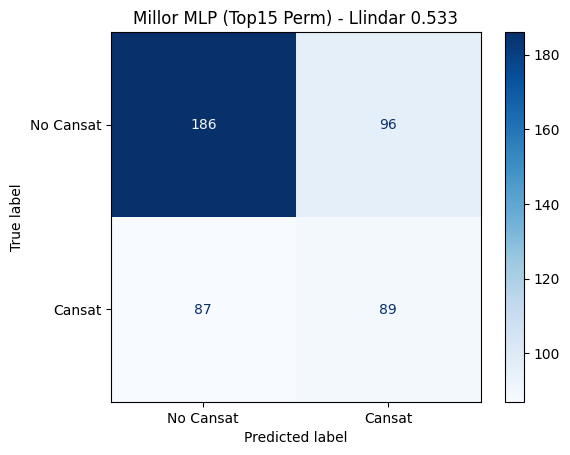

In [ ]:

sel_feats = perm_top_features[15] # Llista de 15 millors features per permutació


print(f"Característiques seleccionades (Top 15 per permutació): {sel_feats}")

num_sel = [f for f in sel_feats if f in numerical_features]
cat_sel = [f for f in sel_feats if f in categorical_features]

# Preprocessador específic per a les característiques seleccionades
# numeric_transformer i categorical_transformer haurien d'estar definits prèviament
# (p.ex., el numeric_transformer inicial amb SimpleImputer(median) i StandardScaler)
transfs = []
if num_sel:
    transfs.append(("num", numeric_transformer, num_sel))
if cat_sel:
    # Assegura't que categorical_transformer està definit (SimpleImputer(most_frequent) + OHE)
    transfs.append(("cat", categorical_transformer, cat_sel))

if not transfs:
    print("Error: No s'han pogut crear transformadors. Comprova num_sel i cat_sel.")
else:
    preproc_top = ColumnTransformer(transfs, remainder="drop") # 'drop' és important

    # Divisió train_intern / validació per a l'ajust del llindar
    # Corregit y_tired_train a y_train
    X_tr_in, X_val, y_tr_in, y_val = train_test_split(
        X_train, y_train, # Utilitza y_train aquí
        test_size=0.20, 
        stratify=y_train, # Estratifica amb y_train
        random_state=42
    )
    print(f"Dimensions X_tr_in: {X_tr_in.shape}, X_val: {X_val.shape}")

    # ------------------------------------------------------------------
    # 1) Pipeline
    # ------------------------------------------------------------------
    # L' MLPClassifier es defineix aquí amb paràmetres base, RandomizedSearchCV els modificarà
    pipe_mlp_final = ImbPipeline([
        ("preprocessor", preproc_top),
        ("smote",        SMOTE(random_state=42)),
        ("mlp",          MLPClassifier(max_iter=1500, random_state=42)) # max_iter augmentat per si de cas
    ])

    # ------------------------------------------------------------------
    # 2) Hiperparàmetres (distribucions àmplies)
    # ------------------------------------------------------------------
    from scipy.stats import uniform, randint

    # S'ha observat que 'lbfgs' pot no funcionar bé amb SMOTE o necessitar moltes iteracions.
    # 'adam' sol ser més robust. Considera eliminar 'lbfgs' si hi ha problemes de convergència.
    param_dist_mlp = {
        "mlp__hidden_layer_sizes": [(randint.rvs(30, 150),),               # 1 capa
                                    (randint.rvs(50, 120), randint.rvs(20,80)),  # 2 capes
                                    (randint.rvs(60, 100), randint.rvs(40,80), randint.rvs(20,60))], # 3 capes (més petites)
        "mlp__activation":         ["relu", "tanh", "logistic"],
        "mlp__solver":             ["adam"], # LBFGS pot ser problemàtic amb batch_size i early_stopping
        "mlp__alpha":              uniform(1e-5, 1e-2),      # Regularització L2
        "mlp__learning_rate":      ["constant", "adaptive"],
        "mlp__learning_rate_init": uniform(1e-4, 1e-3),    
        "mlp__batch_size":         [32, 64, 128], # 256 pot ser massa gran per a aquest dataset
        "mlp__early_stopping":     [True],
        "mlp__n_iter_no_change":   [10, 20], # Més paciència
        "mlp__tol":                [1e-4, 1e-5] # Tolerància per a la convergència
    }

    # Mètrica per a GridSearchCV: F1 per a la classe positiva o ROC AUC
    f1_cls1_scorer = make_scorer(f1_score, pos_label=1)
    # roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, average='macro')

    cv_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # ------------------------------------------------------------------
    # 3) RandomizedSearch
    # ------------------------------------------------------------------
    # n_iter: quantitat de combinacions de paràmetres a provar. 50-100 és un bon punt de partida.
    # verbose=1 per menys output
    rs_mlp = RandomizedSearchCV(
        pipe_mlp_final, param_dist_mlp, n_iter=75, # Reduït n_iter si 100 és massa lent
        scoring=f1_cls1_scorer, cv=cv_final, n_jobs=-1, refit=True,
        verbose=1, random_state=42
    )
    
    # X_tr_in conté totes les característiques originals. 
    # El 'preprocessor' dins del pipeline s'encarregarà de seleccionar només 'sel_feats'.
    print("Iniciant RandomizedSearchCV per MLP...")
    rs_mlp.fit(X_tr_in, y_tr_in)

    best_mlp_final = rs_mlp.best_estimator_
    print("\nMillor CV F1(cl1) per MLP:", round(rs_mlp.best_score_, 4))
    print("Millors paràmetres per MLP:", rs_mlp.best_params_)

    # ------------------------------------------------------------------
    # 4) Llindar òptim (F1 macro) sobre VALIDATION
    # ------------------------------------------------------------------
    # X_val també conté totes les característiques originals. El preprocessador seleccionarà les correctes.
    print("\nOptimitzant llindar de decisió en conjunt de validació...")
    probs_val_mlp = best_mlp_final.predict_proba(X_val)[:, 1]
    
    precision_vals, recall_vals, thresholds_vals = precision_recall_curve(y_val, probs_val_mlp, pos_label=1)
    
    # Excloure llindars trivials 0 i 1 si causen problemes amb F1
    f1_macro_scores_mlp = []
    valid_thresholds_mlp = []
    for t in thresholds_vals:
        if 0 < t < 1: # Evitar llindars extrems si és necessari
            y_pred_temp = (probs_val_mlp >= t).astype(int)
            f1_macro_scores_mlp.append(f1_score(y_val, y_pred_temp, average="macro"))
            valid_thresholds_mlp.append(t)
    
    if not f1_macro_scores_mlp: # Fallback si tots els llindars eren 0 o 1
            f1_macro_scores_mlp = [f1_score(y_val, (probs_val_mlp >= t).astype(int), average="macro") for t in thresholds_vals]
            valid_thresholds_mlp = thresholds_vals

    optimal_idx_mlp = np.argmax(f1_macro_scores_mlp)
    thr_opt_mlp = valid_thresholds_mlp[optimal_idx_mlp]
    print(f"Llindar òptim (F1 Macro) per MLP: {thr_opt_mlp:.4f} (F1-macro a validació: {f1_macro_scores_mlp[optimal_idx_mlp]:.4f})")

    # ------------------------------------------------------------------
    # 5) TEST final amb el millor MLP i llindar òptim
    # ------------------------------------------------------------------
    # X_test també conté totes les característiques originals.
    print("\nAvaluant el millor MLP en el conjunt de test...")
    probs_test_mlp = best_mlp_final.predict_proba(X_test)[:, 1]
    y_pred_final_mlp = (probs_test_mlp >= thr_opt_mlp).astype(int)

    print("\n=== Informe TEST Final per al Millor MLP ===")
    # Corregit y_tired_test a y_test
    print(classification_report(y_test, y_pred_final_mlp, digits=4))

    print(f"Test F1-score (macro) MLP: {f1_score(y_test, y_pred_final_mlp, average='macro'):.4f}")
    print(f"Test F1-score (clase 1) MLP: {f1_score(y_test, y_pred_final_mlp, pos_label=1):.4f}")
    print(f"Test ROC AUC MLP: {roc_auc_score(y_test, probs_test_mlp):.4f}") # probs per ROC AUC

    cm_final_mlp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_final_mlp, # Corregit y_tired_test a y_test
        labels=[0,1], 
        cmap="Blues",
        display_labels=["No Cansat", "Cansat"]
    )
    cm_final_mlp.ax_.set_title(f"Millor MLP (Top15 Perm) - Llindar {thr_opt_mlp:.3f}")
    plt.show()


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,
                                     RepeatedStratifiedKFold,
                                     cross_validate)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import warnings; warnings.filterwarnings("ignore")
import optuna
# ─────────────────── 1. Dades ─────────────────────
TARGET = "TIRED"
df = pd.read_csv("../data/df_cleaned.csv")

df_complete = df.dropna(subset=[TARGET])
X = df_complete.drop(columns=[TARGET]).copy()      # ← sense fuites
y = df_complete[TARGET].astype(int)

num_cols = X.select_dtypes(include="number").columns.tolist()
cat_cols = X.select_dtypes(exclude="number").columns.tolist()

numeric_t = [("imputer", SimpleImputer(strategy="median")),
             ("scaler",  StandardScaler())]

categoric_t = [("imputer", SimpleImputer(strategy="most_frequent")),
               ("ohe",     OneHotEncoder(handle_unknown="ignore",
                                         sparse_output=False))]

preprocessor = ColumnTransformer([
    ("num", Pipeline(numeric_t),  num_cols),
    ("cat", Pipeline(categoric_t), cat_cols)
])

# ─────────────────── 2. Optuna • XGBoost ─────────────────
f1_cls1 = make_scorer(f1_score, pos_label=1)

def objective(trial):
    # ── hiperparàmetres ────────────────────────────
    params = {
        "n_estimators":       trial.suggest_int("n_estimators", 300, 1200, step=100),
        "max_depth":          trial.suggest_int("max_depth", 3, 10),
        "learning_rate":      trial.suggest_float("learning_rate", 1e-3, .3, log=True),
        "subsample":          trial.suggest_float("subsample", .6, 1.0),
        "colsample_bytree":   trial.suggest_float("colsample_bytree", .6, 1.0),
        "gamma":              trial.suggest_float("gamma", 0, 5),
        "min_child_weight":   trial.suggest_int("min_child_weight", 1, 20),
        "scale_pos_weight":   (y.value_counts()[0] / y.value_counts()[1]),
        "reg_alpha":          trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda":         trial.suggest_float("reg_lambda", 0, 1)
    }

    xgb = XGBClassifier(
        **params, objective="binary:logistic",
        eval_metric="logloss", random_state=42, n_jobs=-1
    )

    pipe = ImbPipeline([
        ("prep",  preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf",   xgb)
    ])

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    cv_scores = cross_validate(pipe, X, y,
                               cv=cv, n_jobs=-1,
                               scoring=f1_cls1)
    return np.mean(cv_scores["test_score"])

study = optuna.create_study(direction="maximize",
                            study_name="xgb_tired_f1")
study.optimize(objective, n_trials=40, timeout=3600, show_progress_bar=True)

print("┌─ Millor F1(cl1) CV :", round(study.best_value,4))
print("└─ Millors paràmetres:", study.best_params)

# ─────────────────── 3. Avaluació final ───────────
best_xgb = XGBClassifier(
    **study.best_params,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42, n_jobs=-1
)

final_pipe = ImbPipeline([
    ("prep",  preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf",   best_xgb)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.20, random_state=42, stratify=y)

final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

[I 2025-05-19 23:32:29,002] A new study created in memory with name: xgb_tired_f1
  0%|          | 0/40 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.546241:   2%|▎         | 1/40 [00:06<04:25,  6.80s/it, 6.80/3600 seconds]

[I 2025-05-19 23:32:35,803] Trial 0 finished with value: 0.54624147636993 and parameters: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.1089391834253663, 'subsample': 0.9863099288673614, 'colsample_bytree': 0.9967121022818833, 'gamma': 2.5916213428646175, 'min_child_weight': 10, 'reg_alpha': 0.047069035578307106, 'reg_lambda': 0.25583430911116534}. Best is trial 0 with value: 0.54624147636993.


Best trial: 1. Best value: 0.566421:   5%|▌         | 2/40 [00:12<04:00,  6.32s/it, 12.79/3600 seconds]

[I 2025-05-19 23:32:41,792] Trial 1 finished with value: 0.5664213077245059 and parameters: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.0028204904202641687, 'subsample': 0.612571837056449, 'colsample_bytree': 0.7540241639275477, 'gamma': 0.8974396449726546, 'min_child_weight': 6, 'reg_alpha': 0.0028285525542708356, 'reg_lambda': 0.03219692411310304}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:   8%|▊         | 3/40 [00:13<02:19,  3.76s/it, 13.51/3600 seconds]

[I 2025-05-19 23:32:42,512] Trial 2 finished with value: 0.5181429690200717 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.2609122141152425, 'subsample': 0.9981595938053709, 'colsample_bytree': 0.6697446367757314, 'gamma': 0.6140606918450203, 'min_child_weight': 5, 'reg_alpha': 0.6480147484795673, 'reg_lambda': 0.6632214815851453}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  10%|█         | 4/40 [00:18<02:38,  4.40s/it, 18.88/3600 seconds]

[I 2025-05-19 23:32:47,880] Trial 3 finished with value: 0.5358753894542961 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.013242423150950406, 'subsample': 0.8733994110853001, 'colsample_bytree': 0.681604154163511, 'gamma': 0.8825507725564702, 'min_child_weight': 12, 'reg_alpha': 0.019718923225467422, 'reg_lambda': 0.2891908893290108}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  12%|█▎        | 5/40 [00:19<01:46,  3.03s/it, 19.49/3600 seconds]

[I 2025-05-19 23:32:48,495] Trial 4 finished with value: 0.5476205858100409 and parameters: {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.12910773906631418, 'subsample': 0.9231006802221551, 'colsample_bytree': 0.9579165653102096, 'gamma': 3.2468283447605333, 'min_child_weight': 17, 'reg_alpha': 0.3797512352115362, 'reg_lambda': 0.05390308142057476}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  15%|█▌        | 6/40 [00:23<01:55,  3.40s/it, 23.59/3600 seconds]

[I 2025-05-19 23:32:52,593] Trial 5 finished with value: 0.5505622975545544 and parameters: {'n_estimators': 1100, 'max_depth': 5, 'learning_rate': 0.005375903778361441, 'subsample': 0.7503954227993479, 'colsample_bytree': 0.7428493449843285, 'gamma': 1.6930350357693136, 'min_child_weight': 4, 'reg_alpha': 0.5319051009136567, 'reg_lambda': 0.883088749160811}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  18%|█▊        | 7/40 [00:28<02:06,  3.82s/it, 28.28/3600 seconds]

[I 2025-05-19 23:32:57,286] Trial 6 finished with value: 0.5221374130364962 and parameters: {'n_estimators': 600, 'max_depth': 9, 'learning_rate': 0.021930352470070795, 'subsample': 0.8919225446821359, 'colsample_bytree': 0.8875146531822471, 'gamma': 0.6808269830841346, 'min_child_weight': 7, 'reg_alpha': 0.6310468824547406, 'reg_lambda': 0.26178566620543453}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  20%|██        | 8/40 [00:30<01:42,  3.21s/it, 30.18/3600 seconds]

[I 2025-05-19 23:32:59,182] Trial 7 finished with value: 0.5027226378594014 and parameters: {'n_estimators': 800, 'max_depth': 9, 'learning_rate': 0.1509224634210739, 'subsample': 0.6265705701926273, 'colsample_bytree': 0.6425526003713243, 'gamma': 1.1938538939646948, 'min_child_weight': 11, 'reg_alpha': 0.007346662322187836, 'reg_lambda': 0.18319855124901097}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  22%|██▎       | 9/40 [00:31<01:18,  2.55s/it, 31.27/3600 seconds]

[I 2025-05-19 23:33:00,273] Trial 8 finished with value: 0.5233446651653175 and parameters: {'n_estimators': 900, 'max_depth': 4, 'learning_rate': 0.22638945801426208, 'subsample': 0.6013312206705458, 'colsample_bytree': 0.7173333083270361, 'gamma': 2.7854132762018002, 'min_child_weight': 17, 'reg_alpha': 0.23850213126741393, 'reg_lambda': 0.9664717225992123}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  25%|██▌       | 10/40 [00:34<01:18,  2.62s/it, 34.05/3600 seconds]

[I 2025-05-19 23:33:03,051] Trial 9 finished with value: 0.5653322768023649 and parameters: {'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.00234317556908899, 'subsample': 0.7545370491633274, 'colsample_bytree': 0.9553258557336979, 'gamma': 3.6429888893142808, 'min_child_weight': 2, 'reg_alpha': 0.7617493483921046, 'reg_lambda': 0.16669650859685303}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  28%|██▊       | 11/40 [00:34<00:58,  2.02s/it, 34.72/3600 seconds]

[I 2025-05-19 23:33:03,727] Trial 10 finished with value: 0.555205047318612 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.0010434536057252395, 'subsample': 0.6917517386288271, 'colsample_bytree': 0.8099362230426606, 'gamma': 4.576778447446952, 'min_child_weight': 1, 'reg_alpha': 0.9382267366696662, 'reg_lambda': 0.5155668921573505}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  30%|███       | 12/40 [00:42<01:44,  3.72s/it, 42.31/3600 seconds]

[I 2025-05-19 23:33:11,316] Trial 11 finished with value: 0.563093389152571 and parameters: {'n_estimators': 1200, 'max_depth': 6, 'learning_rate': 0.0015741606792205292, 'subsample': 0.7964303656841227, 'colsample_bytree': 0.8206234668072391, 'gamma': 3.956701775648715, 'min_child_weight': 1, 'reg_alpha': 0.8674836672612993, 'reg_lambda': 0.00948533893578593}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  32%|███▎      | 13/40 [00:43<01:19,  2.93s/it, 43.44/3600 seconds]

[I 2025-05-19 23:33:12,440] Trial 12 finished with value: 0.5635411166517738 and parameters: {'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.0034554285751065457, 'subsample': 0.6946349095863521, 'colsample_bytree': 0.8810274659037125, 'gamma': 0.05018332550051563, 'min_child_weight': 7, 'reg_alpha': 0.7707742721876786, 'reg_lambda': 0.41447350819129414}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  35%|███▌      | 14/40 [00:48<01:35,  3.67s/it, 48.80/3600 seconds]

[I 2025-05-19 23:33:17,802] Trial 13 finished with value: 0.5584182117196331 and parameters: {'n_estimators': 700, 'max_depth': 7, 'learning_rate': 0.003113637872176427, 'subsample': 0.6781697263623963, 'colsample_bytree': 0.7557190929575159, 'gamma': 1.8288267225493038, 'min_child_weight': 4, 'reg_alpha': 0.3210859750451346, 'reg_lambda': 0.10167355119011595}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  38%|███▊      | 15/40 [00:50<01:17,  3.12s/it, 50.65/3600 seconds]

[I 2025-05-19 23:33:19,652] Trial 14 finished with value: 0.5577459962979778 and parameters: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.009096464966933004, 'subsample': 0.7759734450370355, 'colsample_bytree': 0.8782747324092977, 'gamma': 3.6467793173959304, 'min_child_weight': 8, 'reg_alpha': 0.7789421546999002, 'reg_lambda': 0.444367580191088}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  40%|████      | 16/40 [00:51<01:00,  2.51s/it, 51.73/3600 seconds]

[I 2025-05-19 23:33:20,734] Trial 15 finished with value: 0.5492068840659984 and parameters: {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.023490023788743458, 'subsample': 0.7391045223775037, 'colsample_bytree': 0.9326703212502032, 'gamma': 4.937317655168372, 'min_child_weight': 3, 'reg_alpha': 0.15319751801574, 'reg_lambda': 0.13944361061355093}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  42%|████▎     | 17/40 [00:53<00:51,  2.23s/it, 53.33/3600 seconds]

[I 2025-05-19 23:33:22,334] Trial 16 finished with value: 0.5600431274926271 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.0021061065041784754, 'subsample': 0.8353304942289294, 'colsample_bytree': 0.6035431157697128, 'gamma': 2.00919827563243, 'min_child_weight': 20, 'reg_alpha': 0.4561867911560839, 'reg_lambda': 0.6126946216226714}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  45%|████▌     | 18/40 [00:54<00:39,  1.81s/it, 54.15/3600 seconds]

[I 2025-05-19 23:33:23,151] Trial 17 finished with value: 0.5485022152337746 and parameters: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.045498656525013136, 'subsample': 0.6556909124847221, 'colsample_bytree': 0.7828457065732444, 'gamma': 4.064090190470401, 'min_child_weight': 6, 'reg_alpha': 0.993935811243795, 'reg_lambda': 0.34637284453620065}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 1. Best value: 0.566421:  48%|████▊     | 19/40 [00:57<00:48,  2.30s/it, 57.61/3600 seconds]

[I 2025-05-19 23:33:26,614] Trial 18 finished with value: 0.5514270893801563 and parameters: {'n_estimators': 900, 'max_depth': 7, 'learning_rate': 0.007870086190390835, 'subsample': 0.7127171338920733, 'colsample_bytree': 0.848926656792974, 'gamma': 3.210021585284806, 'min_child_weight': 9, 'reg_alpha': 0.5948724154680873, 'reg_lambda': 0.1786800622461392}. Best is trial 1 with value: 0.5664213077245059.


Best trial: 19. Best value: 0.567645:  50%|█████     | 20/40 [00:59<00:44,  2.21s/it, 59.61/3600 seconds]

[I 2025-05-19 23:33:28,619] Trial 19 finished with value: 0.5676454122750604 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.0034052673521274487, 'subsample': 0.8319288743345203, 'colsample_bytree': 0.9367769713248748, 'gamma': 2.1752676332702547, 'min_child_weight': 13, 'reg_alpha': 0.7852524757646594, 'reg_lambda': 0.03452569798754964}. Best is trial 19 with value: 0.5676454122750604.


Best trial: 20. Best value: 0.571135:  52%|█████▎    | 21/40 [01:01<00:41,  2.20s/it, 61.78/3600 seconds]

[I 2025-05-19 23:33:30,787] Trial 20 finished with value: 0.5711353323273752 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.004760997043163551, 'subsample': 0.8290169224834714, 'colsample_bytree': 0.7150284437143839, 'gamma': 1.3905344399249935, 'min_child_weight': 13, 'reg_alpha': 0.20080052684257865, 'reg_lambda': 0.007361781930219087}. Best is trial 20 with value: 0.5711353323273752.


Best trial: 20. Best value: 0.571135:  55%|█████▌    | 22/40 [01:04<00:39,  2.21s/it, 64.02/3600 seconds]

[I 2025-05-19 23:33:33,021] Trial 21 finished with value: 0.5702680239466907 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.005170431630772018, 'subsample': 0.841625004069887, 'colsample_bytree': 0.7265502796380705, 'gamma': 1.4230779713330617, 'min_child_weight': 13, 'reg_alpha': 0.11790438203723817, 'reg_lambda': 0.009151892441969012}. Best is trial 20 with value: 0.5711353323273752.


Best trial: 20. Best value: 0.571135:  57%|█████▊    | 23/40 [01:05<00:36,  2.13s/it, 65.97/3600 seconds]

[I 2025-05-19 23:33:34,969] Trial 22 finished with value: 0.5699072013161552 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.005432958490412557, 'subsample': 0.8320351992447669, 'colsample_bytree': 0.7039760261882305, 'gamma': 1.4121336448943616, 'min_child_weight': 14, 'reg_alpha': 0.2491858177955827, 'reg_lambda': 0.08661453934899765}. Best is trial 20 with value: 0.5711353323273752.


Best trial: 20. Best value: 0.571135:  60%|██████    | 24/40 [01:07<00:33,  2.07s/it, 67.89/3600 seconds]

[I 2025-05-19 23:33:36,896] Trial 23 finished with value: 0.5696913756241236 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.0059705777512169145, 'subsample': 0.8302226252670218, 'colsample_bytree': 0.7085962152665175, 'gamma': 1.4859832607769303, 'min_child_weight': 14, 'reg_alpha': 0.14058412258157135, 'reg_lambda': 0.0037449339604119264}. Best is trial 20 with value: 0.5711353323273752.


Best trial: 20. Best value: 0.571135:  62%|██████▎   | 25/40 [01:09<00:30,  2.03s/it, 69.82/3600 seconds]

[I 2025-05-19 23:33:38,817] Trial 24 finished with value: 0.5605179854882246 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.012536219496679216, 'subsample': 0.9325306646190823, 'colsample_bytree': 0.6343254295541865, 'gamma': 0.1427530349469177, 'min_child_weight': 15, 'reg_alpha': 0.2377830328624853, 'reg_lambda': 0.11009532955000889}. Best is trial 20 with value: 0.5711353323273752.


Best trial: 20. Best value: 0.571135:  65%|██████▌   | 26/40 [01:12<00:30,  2.20s/it, 72.43/3600 seconds]

[I 2025-05-19 23:33:41,435] Trial 25 finished with value: 0.5672771197436988 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.00502556949007271, 'subsample': 0.8790776708442917, 'colsample_bytree': 0.7003200317987678, 'gamma': 1.2794651722966675, 'min_child_weight': 15, 'reg_alpha': 0.14662107442420125, 'reg_lambda': 0.7939989253221398}. Best is trial 20 with value: 0.5711353323273752.


Best trial: 20. Best value: 0.571135:  68%|██████▊   | 27/40 [01:14<00:28,  2.20s/it, 74.61/3600 seconds]

[I 2025-05-19 23:33:43,618] Trial 26 finished with value: 0.5614150273348494 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.0091551125060523, 'subsample': 0.8520533243321181, 'colsample_bytree': 0.7324630841708958, 'gamma': 2.2563680608629317, 'min_child_weight': 18, 'reg_alpha': 0.3288384600767946, 'reg_lambda': 0.2207518683166433}. Best is trial 20 with value: 0.5711353323273752.


Best trial: 20. Best value: 0.571135:  70%|███████   | 28/40 [01:16<00:23,  1.99s/it, 76.12/3600 seconds]

[I 2025-05-19 23:33:45,120] Trial 27 finished with value: 0.5333923284235985 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.04435409299428802, 'subsample': 0.8015362759712316, 'colsample_bytree': 0.7909614586855324, 'gamma': 1.4626395830017453, 'min_child_weight': 12, 'reg_alpha': 0.2586788390139758, 'reg_lambda': 0.345660287598999}. Best is trial 20 with value: 0.5711353323273752.


Best trial: 20. Best value: 0.571135:  72%|███████▎  | 29/40 [01:20<00:28,  2.64s/it, 80.26/3600 seconds]

[I 2025-05-19 23:33:49,266] Trial 28 finished with value: 0.5654728754211312 and parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.0014858563552213372, 'subsample': 0.9112429092055316, 'colsample_bytree': 0.6638266986565059, 'gamma': 0.467681582240727, 'min_child_weight': 15, 'reg_alpha': 0.09486277109695229, 'reg_lambda': 0.12147136850578077}. Best is trial 20 with value: 0.5711353323273752.


Best trial: 20. Best value: 0.571135:  75%|███████▌  | 30/40 [01:23<00:27,  2.78s/it, 83.38/3600 seconds]

[I 2025-05-19 23:33:52,382] Trial 29 finished with value: 0.5664839287343709 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.004478046515286756, 'subsample': 0.95035457373553, 'colsample_bytree': 0.7694262922147543, 'gamma': 2.869426418170507, 'min_child_weight': 10, 'reg_alpha': 0.40353880996735625, 'reg_lambda': 0.08433609613714599}. Best is trial 20 with value: 0.5711353323273752.


Best trial: 20. Best value: 0.571135:  78%|███████▊  | 31/40 [01:25<00:22,  2.51s/it, 85.26/3600 seconds]

[I 2025-05-19 23:33:54,259] Trial 30 finished with value: 0.5387240181722956 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.03647712747930789, 'subsample': 0.7866650826755501, 'colsample_bytree': 0.6875960141811793, 'gamma': 1.125793414320194, 'min_child_weight': 13, 'reg_alpha': 0.08970957232446819, 'reg_lambda': 0.31384703708202094}. Best is trial 20 with value: 0.5711353323273752.


Best trial: 20. Best value: 0.571135:  80%|████████  | 32/40 [01:27<00:18,  2.34s/it, 87.19/3600 seconds]

[I 2025-05-19 23:33:56,197] Trial 31 finished with value: 0.5696904795444309 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.006456710411816599, 'subsample': 0.835134861131658, 'colsample_bytree': 0.7281893847258285, 'gamma': 1.6265836562880434, 'min_child_weight': 14, 'reg_alpha': 0.1795413992971782, 'reg_lambda': 0.0050056928985512976}. Best is trial 20 with value: 0.5711353323273752.


Best trial: 32. Best value: 0.572093:  82%|████████▎ | 33/40 [01:28<00:14,  2.14s/it, 88.86/3600 seconds]

[I 2025-05-19 23:33:57,866] Trial 32 finished with value: 0.5720925953235778 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.004307727485728677, 'subsample': 0.8579715448441685, 'colsample_bytree': 0.7010096268266596, 'gamma': 2.5064015259742805, 'min_child_weight': 16, 'reg_alpha': 0.0900872401511853, 'reg_lambda': 0.06646114298053622}. Best is trial 32 with value: 0.5720925953235778.


Best trial: 32. Best value: 0.572093:  85%|████████▌ | 34/40 [01:30<00:12,  2.05s/it, 90.73/3600 seconds]

[I 2025-05-19 23:33:59,729] Trial 33 finished with value: 0.5560182343555634 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.012981572698334947, 'subsample': 0.8188492728154952, 'colsample_bytree': 0.6576115498873707, 'gamma': 2.4803910441517, 'min_child_weight': 17, 'reg_alpha': 0.20892823617594458, 'reg_lambda': 0.2254861905076605}. Best is trial 32 with value: 0.5720925953235778.


Best trial: 32. Best value: 0.572093:  88%|████████▊ | 35/40 [01:34<00:12,  2.43s/it, 94.02/3600 seconds]

[I 2025-05-19 23:34:03,024] Trial 34 finished with value: 0.5701460746295057 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.004084423308395326, 'subsample': 0.8577245853556978, 'colsample_bytree': 0.6202765768992454, 'gamma': 2.4583639743971357, 'min_child_weight': 11, 'reg_alpha': 0.05935428179257951, 'reg_lambda': 0.08104902034043608}. Best is trial 32 with value: 0.5720925953235778.


Best trial: 32. Best value: 0.572093:  90%|█████████ | 36/40 [01:37<00:10,  2.69s/it, 97.33/3600 seconds]

[I 2025-05-19 23:34:06,332] Trial 35 finished with value: 0.5676831087268611 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.004022481557304368, 'subsample': 0.871376237717806, 'colsample_bytree': 0.6047292388084025, 'gamma': 2.366493056868124, 'min_child_weight': 11, 'reg_alpha': 0.056848015459998825, 'reg_lambda': 0.09337292799552646}. Best is trial 32 with value: 0.5720925953235778.


Best trial: 32. Best value: 0.572093:  92%|█████████▎| 37/40 [01:43<00:10,  3.61s/it, 103.09/3600 seconds]

[I 2025-05-19 23:34:12,098] Trial 36 finished with value: 0.5703928084339961 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.0020912534081955303, 'subsample': 0.9745226420178439, 'colsample_bytree': 0.6809990097536488, 'gamma': 1.9864349812784237, 'min_child_weight': 10, 'reg_alpha': 0.09609187260448329, 'reg_lambda': 0.04214714541406398}. Best is trial 32 with value: 0.5720925953235778.


Best trial: 32. Best value: 0.572093:  95%|█████████▌| 38/40 [01:46<00:06,  3.49s/it, 106.28/3600 seconds]

[I 2025-05-19 23:34:15,286] Trial 37 finished with value: 0.5632847313167308 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.002029559884361779, 'subsample': 0.9663290330592995, 'colsample_bytree': 0.6793239747559325, 'gamma': 1.944845644938657, 'min_child_weight': 9, 'reg_alpha': 0.30222651583676596, 'reg_lambda': 0.04964967468287962}. Best is trial 32 with value: 0.5720925953235778.


Best trial: 32. Best value: 0.572093:  98%|█████████▊| 39/40 [01:50<00:03,  3.62s/it, 110.22/3600 seconds]

[I 2025-05-19 23:34:19,224] Trial 38 finished with value: 0.5613431216961986 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.0011899003427019224, 'subsample': 0.9966412333178848, 'colsample_bytree': 0.7521188037932458, 'gamma': 0.8274414504337275, 'min_child_weight': 19, 'reg_alpha': 0.10639042873980364, 'reg_lambda': 0.2297404396743537}. Best is trial 32 with value: 0.5720925953235778.


Best trial: 32. Best value: 0.572093: 100%|██████████| 40/40 [01:52<00:00,  2.81s/it, 112.22/3600 seconds]


[I 2025-05-19 23:34:21,227] Trial 39 finished with value: 0.564305748262068 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.0028463526433142707, 'subsample': 0.970250229976151, 'colsample_bytree': 0.6437792045456957, 'gamma': 2.7525125442806995, 'min_child_weight': 16, 'reg_alpha': 0.0012239743610675813, 'reg_lambda': 0.710859317044317}. Best is trial 32 with value: 0.5720925953235778.
┌─ Millor F1(cl1) CV : 0.5721
└─ Millors paràmetres: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.004307727485728677, 'subsample': 0.8579715448441685, 'colsample_bytree': 0.7010096268266596, 'gamma': 2.5064015259742805, 'min_child_weight': 16, 'reg_alpha': 0.0900872401511853, 'reg_lambda': 0.06646114298053622}
              precision    recall  f1-score   support

           0     0.6953    0.6312    0.6617       282
           1     0.4851    0.5568    0.5185       176

    accuracy                         0.6026       458
   macro avg     0.5902    0.5940    0.5901 